In [1]:
# === SEKCJA 1: IMPORT I KONFIGURACJA ===
import pandas as pd
import numpy as np
import re
import warnings

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from IPython.display import display
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

print("Wczytywanie danych...")
df_main = pd.read_csv('data.csv', sep=',', low_memory=False)
df_ulic = pd.read_csv('Ulic.csv', sep=',')
# ZMIANA: Wczytanie nowej bazy lokalizacji
df_lokalizacje = pd.read_csv('lokalizacja.csv', sep=',', on_bad_lines='skip')
print("Wszystkie pliki wczytane.")

Wczytywanie danych...
Wszystkie pliki wczytane.


In [2]:
# === SEKCJA 2: PRZYGOTOWANIE DANYCH (ZE WZBOGACENIEM KONTEKSTOWYM) ===

# --- Krok 1: Przetworzenie bazy TERYT (lokalizacja.csv) ---
print("Przetwarzanie bazy lokalizacji TERYT...")
df_lokalizacje.columns = ['LokalizacjaID', 'ParentID', 'Nazwa', 'Typ', 'Sciezka']
df_lokalizacje_ulic = df_lokalizacje[df_lokalizacje['Typ'] == 'Ul.'].copy()
df_lokalizacje_ulic['Nazwa_clean'] = df_lokalizacje_ulic['Nazwa'].str.lower()

# Funkcja do wyciągania miasta ze ścieżki
def get_city_from_path(path):
    if not isinstance(path, str):
        return None
    parts = [p.strip() for p in path.split(',')]
    # Dla Warszawy miasto jest na 2. pozycji (index 1), dla innych na 3. (index 2)
    if 'warszawa' in parts[0].lower():
        if len(parts) > 1: return parts[1].lower()
    else:
        if len(parts) > 2: return parts[2].lower()
    return None

df_lokalizacje_ulic['Miasto'] = df_lokalizacje_ulic['Sciezka'].apply(get_city_from_path)
df_lokalizacje_ulic.dropna(subset=['Miasto'], inplace=True)

# Stworzenie mapy: miasto -> "ulica1 ulica2 ulica3..."
print("Tworzenie mapy miasto -> lista ulic...")
city_to_streets_map = df_lokalizacje_ulic.groupby('Miasto')['Nazwa_clean'].agg(lambda x: ' '.join(x)).to_dict()

# --- Krok 2: Przetworzenie głównego zbioru danych (jak poprzednio) ---
df_ulic.rename(columns={'Name': 'NAZWA_ULICY'}, inplace=True)
df_ulic.dropna(subset=['SymUl', 'NAZWA_ULICY'], inplace=True)
street_dictionary = pd.Series(df_ulic.NAZWA_ULICY.values, index=df_ulic.SymUl).to_dict()

df_processed = df_main.copy()
df_processed.dropna(subset=['Area', 'Price', 'Description', 'Location', 'StreetNumber'], inplace=True)

def process_location(row):
    location_str, district, street, city = row['Location'], np.nan, np.nan, np.nan
    if isinstance(location_str, str):
        parts = [p.strip() for p in location_str.split(',')]
        if len(parts) >= 2: city = parts[1].lower()
        if len(parts) >= 3 and 'warszawa' in parts[1].lower(): district = parts[2]
    if pd.notna(row['StreetNumber']):
        try:
            street_sym = int(row['StreetNumber'])
            if street_sym in street_dictionary: street = street_dictionary[street_sym]
        except (ValueError, TypeError): pass
    if pd.isna(street) and isinstance(location_str, str) and len(location_str.split(',')) >= 4:
        street = location_str.split(',')[3].strip()
    if isinstance(street, str):
        street = re.sub(r'^(ul\\.|al\\.|pl\\.)\\s*', '', street, flags=re.IGNORECASE).lower()
        if len(street) < 3: street = np.nan
    return pd.Series([district, street, city])

df_processed[['District', 'Ulica_clean', 'Miasto']] = df_processed.apply(process_location, axis=1)
df_processed.dropna(subset=['Ulica_clean', 'District', 'Miasto'], inplace=True)

# --- Krok 3: Ograniczenie zbioru do ulic z wystarczającą liczbą próbek ---
MIN_SAMPLES_PER_STREET = 25
street_counts = df_processed['Ulica_clean'].value_counts()
streets_to_remove = street_counts[street_counts < MIN_SAMPLES_PER_STREET].index
df_model_ready = df_processed[~df_processed['Ulica_clean'].isin(streets_to_remove)].copy()

# --- Krok 4: Wzbogacenie danych o kontekst ulic z danego miasta ---
print("Wzbogacanie danych o kontekst ulic...")
df_model_ready['candidate_streets'] = df_model_ready['Miasto'].map(city_to_streets_map).fillna('')

print(f"Finalny zbiór danych gotowy. Wiersze: {len(df_model_ready)}, Ulice: {df_model_ready['Ulica_clean'].nunique()}")

Przetwarzanie bazy lokalizacji TERYT...
Tworzenie mapy miasto -> lista ulic...
Wzbogacanie danych o kontekst ulic...
Finalny zbiór danych gotowy. Wiersze: 52543, Ulice: 682


In [3]:
# === SEKCJA 3: INŻYNIERIA CECH DO SIECI NEURONOWEJ ===

# Funkcja do czyszczenia tekstu
def clean_text(text): return re.sub(r'[^a-ząęółśżźćń ]', '', str(text).lower())
df_model_ready['description_clean'] = df_model_ready['Description'].apply(clean_text)

# ZMIANA: Stworzenie nowej, wzbogaconej cechy tekstowej
df_model_ready['enriched_description'] = df_model_ready['description_clean'] + " możliwe ulice " + df_model_ready['candidate_streets']

# Funkcja do ekstrakcji kontekstu zabudowy
def get_building_context(description):
    desc = str(description).lower()
    if any(word in desc for word in ['kamienica', 'przedwojenna', 'cegły', 'historyczna']): return 'kamienica'
    if any(word in desc for word in ['blok', 'wielka płyta', 'wieżowiec', 'płyt', 'blokowisko']): return 'blok'
    if any(word in desc for word in ['apartamentowiec', 'nowe budownictwo', 'nowy budynek', 'inwestycja', 'developerski']): return 'apartamentowiec'
    if any(word in desc for word in ['dom', 'szeregowiec', 'bliźniak', 'segment']): return 'dom'
    return 'inny'
df_model_ready['BuildingContext'] = df_model_ready['Description'].apply(get_building_context)

# Tokenizer będzie teraz uczony na wzbogaconym opisie
MAX_WORDS, MAX_LEN = 20000, 300 # Zwiększamy MAX_LEN, bo dodaliśmy tekst
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df_model_ready['enriched_description'])
sequences = tokenizer.texts_to_sequences(df_model_ready['enriched_description'])
X_text = pad_sequences(sequences, maxlen=MAX_LEN)

numeric_features = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors']
numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
X_numeric = numeric_pipeline.fit_transform(df_model_ready[numeric_features])

categorical_features = ['District', 'BuildingType', 'BuildingContext']
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
X_categorical = cat_pipeline.fit_transform(df_model_ready[categorical_features])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_model_ready['Ulica_clean'])
num_classes = len(label_encoder.classes_)
print("Dane przygotowane do treningu.")

Dane przygotowane do treningu.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 300)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 300, 128)          │       2,560,000 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 256)               │         263,168 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numeric_input (InputLayer)    │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ categorical_input             │ (None, 42)                │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 303)               │               0 │ bidirectional[0][0],       │
│                               │                           │                 │ numeric_input[0][0],       │
│                               │                           │                 │ categorical_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 512)               │         155,648 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 512)               │           2,048 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │         131,328 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256)               │           1,024 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 256)               │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 682)               │         175,274 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,288,490 (12.54 MB)

 Trainable params: 3,286,954 (12.54 MB)

 Non-trainable params: 1,536 (6.00 KB)


Rozpoczynam trening sieci neuronowej (wersja z wzbogaconym kontekstem)...
Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1324s 8s/step - accuracy: 0.0707 - loss: 5.6925 - val_accuracy: 0.1104 - val_loss: 5.4815 - learning_rate: 0.0010
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1603s 10s/step - accuracy: 0.1688 - loss: 3.5917 - val_accuracy: 0.1855 - val_loss: 4.2829 - learning_rate: 0.0010
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1603s 10s/step - accuracy: 0.1993 - loss: 3.2693 - val_accuracy: 0.2324 - val_loss: 3.3266 - learning_rate: 0.0010
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1601s 10s/step - accuracy: 0.2431 - loss: 3.0364 - val_accuracy: 0.2681 - val_loss: 2.9492 - learning_rate: 0.0010
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1571s 10s/step - accuracy: 0.2861 - loss: 2.8329 - val_accuracy: 0.2887 - val_loss: 2.8020 - learning_rate: 0.0010
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1563s 9s/step - accuracy: 0.3207 - loss: 2.6489 - val_accuracy: 0.3136 - val_loss: 2.7252 - learning_rate: 0.00

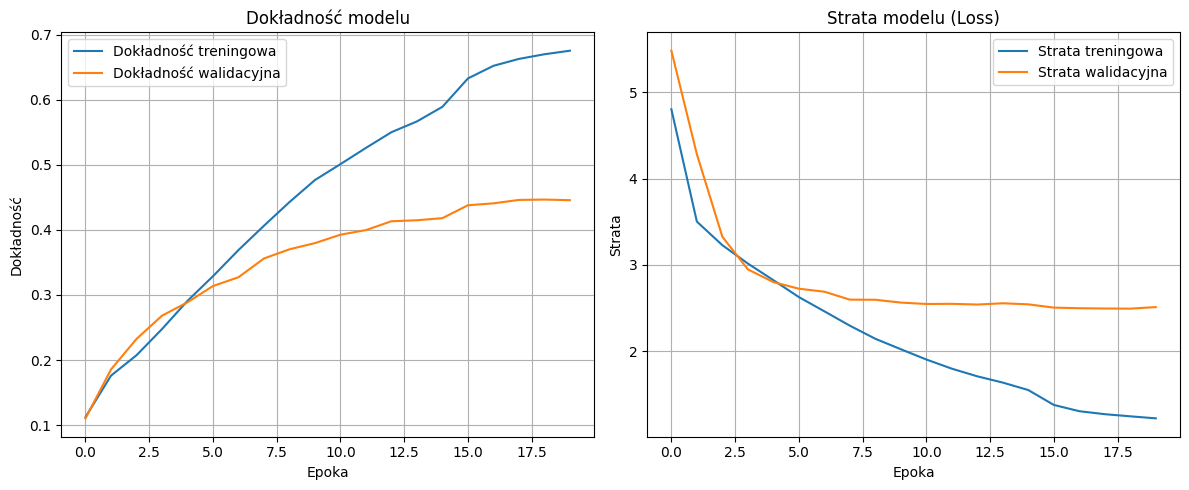

In [4]:
# === SEKCJA 4: BUDOWA I TRENING (WERSJA FINALNA) ===

input_text = Input(shape=(MAX_LEN,), name='text_input')
input_numeric = Input(shape=(X_numeric.shape[1],), name='numeric_input')
input_categorical = Input(shape=(X_categorical.shape[1],), name='categorical_input')

embedding_layer = Embedding(input_dim=MAX_WORDS, output_dim=128)(input_text)
lstm_layer = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(embedding_layer)
concatenated = Concatenate()([lstm_layer, input_numeric, input_categorical])

x = Dense(512, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[input_text, input_numeric, input_categorical], outputs=output_layer)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

X_train_text, X_val_text, X_train_num, X_val_num, X_train_cat, X_val_cat, y_train, y_val = train_test_split(
    X_text, X_numeric, X_categorical, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

print("\nRozpoczynam trening sieci neuronowej (wersja z wzbogaconym kontekstem)...")
history = model.fit(
    [X_train_text, X_train_num, X_train_cat], y_train,
    validation_data=([X_val_text, X_val_num, X_val_cat], y_val),
    epochs=20,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr]
)

model.save('street_predictor_final_v7.keras')
print("\nModel został wytrenowany i zapisany jako 'street_predictor_final_v7.keras'.")

# Wizualizacja
print("\nGenerowanie wykresów uczenia...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.plot(history.history['accuracy'], label='Dokładność treningowa'); plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna'); plt.title('Dokładność modelu'); plt.xlabel('Epoka'); plt.ylabel('Dokładność'); plt.legend(); plt.grid(True)
plt.subplot(1, 2, 2); plt.plot(history.history['loss'], label='Strata treningowa'); plt.plot(history.history['val_loss'], label='Strata walidacyjna'); plt.title('Strata modelu (Loss)'); plt.xlabel('Epoka'); plt.ylabel('Strata'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

In [5]:
# === SEKCJA 5: PREDYKCJA NA CAŁEJ BAZIE I WZBOGACENIE DANYCH ===

print("Przygotowywanie całego zbioru danych do predykcji...")

df_predict_base = df_main.copy()

# Stosowanie tych samych transformacji, co na zbiorze treningowym
df_predict_base[['District', 'Ulica_clean']] = df_predict_base.apply(process_location, axis=1)
df_predict_base['description_clean'] = df_predict_base['Description'].apply(clean_text)
df_predict_base['BuildingContext'] = df_predict_base['Description'].apply(get_building_context)

# Wypełnienie braków
df_predict_base['description_clean'].fillna('brak opisu', inplace=True)
for col in numeric_features:
    df_predict_base[col].fillna(0, inplace=True)
for col in categorical_features:
    df_predict_base[col].fillna('missing', inplace=True)

# Transformacja danych
sequences_pred = tokenizer.texts_to_sequences(df_predict_base['description_clean'])
X_text_full = pad_sequences(sequences_pred, maxlen=MAX_LEN)
X_numeric_full = numeric_pipeline.transform(df_predict_base[numeric_features])
X_categorical_full = cat_pipeline.transform(df_predict_base[categorical_features])

print("Generowanie predykcji dla całego zbioru danych...")
predictions_proba = model.predict([X_text_full, X_numeric_full, X_categorical_full])
predicted_labels_encoded = np.argmax(predictions_proba, axis=1)
predicted_street_names = label_encoder.inverse_transform(predicted_labels_encoded)
predicted_probabilities = np.max(predictions_proba, axis=1)

df_predict_base['Predicted_Ulica'] = predicted_street_names
df_predict_base['Predicted_Ulica_Prob'] = predicted_probabilities

print("Predykcja zakończona. Dane zostały wzbogacone.")

Przygotowywanie całego zbioru danych do predykcji...


ValueError: Columns must be same length as key

In [ ]:
# === SEKCJA 6: WERYFIKACJA I KOREKTA PREDYKCJI (WERSJA POPRAWIONA) ===

print("Tworzenie mapy ulica -> dzielnica na podstawie danych treningowych...")
# Używamy df_model_ready, bo zawiera tylko te ulice i dzielnice, na których model był uczony
street_to_district_map = df_model_ready.drop_duplicates(subset='Ulica_clean').set_index('Ulica_clean')['District'].to_dict()

# --- Korekta predykcji ---
print("Weryfikacja i korekta predykcji w oparciu o dzielnicę...")

# Pobierz top 3 predykcje i ich prawdopodobieństwa
top_k = 3
top_k_indices = np.argsort(predictions_proba, axis=1)[:, -top_k:]
top_k_probs = np.sort(predictions_proba, axis=1)[:, -top_k:]

corrected_streets = []
corrected_probs = []
correction_counter = 0

for i in range(len(df_predict_base)):
    original_district = df_predict_base.loc[i, 'District']
    is_corrected = False
    
    # Sprawdzamy predykcje od najlepszej do najgorszej (w ramach top_k)
    for j in range(top_k - 1, -1, -1):
        pred_street_idx = top_k_indices[i, j]
        pred_street_name = label_encoder.classes_[pred_street_idx]
        pred_street_district = street_to_district_map.get(pred_street_name)

        # Jeśli dzielnica jest znana i zgadza się z oryginalną, akceptujemy tę predykcję
        if pd.notna(original_district) and original_district != 'missing' and original_district == pred_street_district:
            corrected_streets.append(pred_street_name)
            corrected_probs.append(top_k_probs[i, j])
            if j < top_k - 1: # Jeśli nie była to pierwsza (najlepsza) predykcja
                correction_counter += 1
            is_corrected = True
            break
    
    # Jeśli żadna z top_k predykcji nie pasowała, bierzemy pierwotną (najlepszą)
    if not is_corrected:
        corrected_streets.append(df_predict_base.loc[i, 'Predicted_Ulica'])
        corrected_probs.append(df_predict_base.loc[i, 'Predicted_Ulica_Prob'])

# Zastąpienie starych predykcji nowymi, skorygowanymi
df_predict_base['Corrected_Ulica'] = corrected_streets
df_predict_base['Corrected_Ulica_Prob'] = corrected_probs

print(f"Liczba predykcji skorygowanych na podstawie dzielnicy: {correction_counter}")

# --- Ponowna weryfikacja po korekcie ---
df_predict_base['Corrected_Ulica_District'] = df_predict_base['Corrected_Ulica'].map(street_to_district_map)

# ZMIANA: Dodanie brakującej definicji funkcji verify_prediction
def verify_prediction(row):
    # Sprawdzamy tylko dla wierszy, gdzie mamy oryginalną dzielnicę (nie 'missing' lub NaN)
    if pd.notna(row['District']) and row['District'] != 'missing':
        # Porównujemy oryginalną dzielnicę z dzielnicą przypisaną do SKORYGOWANEJ ulicy
        if row['District'] == row['Corrected_Ulica_District']:
            return 'Zgodna'
        else:
            return 'Niezgodna'
    return 'Brak danych do weryfikacji'

df_predict_base['Prediction_Status'] = df_predict_base.apply(verify_prediction, axis=1)

# Wyświetlanie statystyk spójności
print("\nStatystyki spójności po korekcie:")
print(df_predict_base['Prediction_Status'].value_counts())

# Wyświetlanie przykładów niezgodnych predykcji (jak ta, którą znalazłeś)
print("\nPrzykładowe 10 losowych niezgodnych predykcji:")
display_cols_check = ['SaleId', 'Location', 'District', 'Corrected_Ulica', 'Corrected_Ulica_District', 'Corrected_Ulica_Prob', 'Description']
display(df_predict_base[df_predict_base['Prediction_Status'] == 'Niezgodna'][display_cols_check].sample(10, random_state=1))

# Wyświetlanie przykładowych wyników końcowych
print("\nPrzykładowe 25 losowych wierszy z uzupełnionymi i skorygowanymi danymi:")
display_cols = ['SaleId', 'Location', 'District', 'Corrected_Ulica', 'Corrected_Ulica_District', 'Prediction_Status', 'Corrected_Ulica_Prob', 'Price', 'Area']
display(df_predict_base[display_cols].sample(25, random_state=42))

# Zapis do pliku CSV
output_filename_corrected = 'data_with_corrected_streets.csv'
df_predict_base.to_csv(output_filename_corrected, index=False, sep=',')
print(f"\nFinalny DataFrame ({len(df_predict_base)} wierszy) zapisano do pliku: {output_filename_corrected}")

In [ ]:
# === SEKCJA 7: OBLICZENIE DOKŁADNOŚCI NA POZIOMIE DZIELNIC ===

print("Obliczanie dokładności predykcji na poziomie dzielnic (na zbiorze walidacyjnym)...")

# 1. Wykonaj predykcję na zbiorze walidacyjnym
y_pred_proba_val = model.predict([X_val_text, X_val_num, X_val_cat])
y_pred_encoded_val = np.argmax(y_pred_proba_val, axis=1)

# 2. Odkoduj przewidziane i prawdziwe NAZWY ULIC
predicted_streets_val = label_encoder.inverse_transform(y_pred_encoded_val)
true_streets_val = label_encoder.inverse_transform(y_val)

# 3. Zmapuj ulice na ich DZIELNICE
# Używamy tej samej mapy co w kroku weryfikacji
predicted_districts_val = [street_to_district_map.get(s, 'nieznana') for s in predicted_streets_val]
true_districts_val = [street_to_district_map.get(s, 'nieznana') for s in true_streets_val]

# 4. Oblicz dokładność
from sklearn.metrics import accuracy_score
district_accuracy = accuracy_score(true_districts_val, predicted_districts_val)

print(f"\nDokładność predykcji na poziomie ulic (val_accuracy): {history.history['val_accuracy'][-1]:.2%}")
print(f"Dokładność predykcji na poziomie dzielnic (obliczona): {district_accuracy:.2%}")

# Ta metryka pokazuje, jak często model, nawet jeśli pomyli się co do dokładnej ulicy,
# to i tak poprawnie wskazuje jej dzielnicę.